# Master IBM Maximo Visual Inspection APIs - Create an 'Image Inferencer & Inspection Report' in 37 minutes

**Last Updated** ⏰ 07 July 2025 <br>
**Author:** 👨‍💻 <a href="https://www.linkedin.com/in/christophe-lucas-a5abab28/" target="_blank">Christophe Lucas</a> - with the help of his local <a href="https://www.linkedin.com/feed/update/urn:li:activity:7345223975897088000/" target="_blank"> Multi LLM System for 💬 Q&A + 👩‍💻 Coding + 📄 Doc Interrogation</a> machine.<br>
**Disclaimer:** ⚠️ This code is delivered as-is and is NOT formal IBM product or documentation in any way.

## 🌎 Notebook Overview & Prerequisites

In this notebook, you will:
1. **Setup** Install required python packages. Get connection details to your MVI instance. Download, discover then upload MVI pre-labeled data sets (i.e. movies of solar panels containing `LichenGrowth` or `BirdDrop` defects) and trained models that will be used throughout this recipe.
2. **Discover the MVI APIs** Learn what APIs are available and play with a few, including the key `/dlapis/{id}` one for image inference. 
3. **Put MVI APIs into practice** Learn how to get detected defect coordinates (be them *rectangles* or *polygons*), and how to calculate the area they occupy on a given image.
4. **Image Inferencer & Inspection Report** Build a GUI to load an image, select a deployed model, send the image for inference on your MVI instance, display the defects detected on it and provide a summary report of the inspection results.

⚠️ **NOTE** ⚠️ With this notebook, you are provided with 'solar panel' ready-to-use data sets and models that were created as part of this <a href="https://github.com/IBM/mas-drone-to-fix-watsonx" target="_blank">From Drone to Fix - Solar Farm Inspection using IBM Maximo & Watsonx</a> show. Note however that if you have existing deployed models in MVI and images to test, you can use them - all the API calls herein should work with *any* MVI Object Detection or Segmentation model.

**IBM Product Used**: <a href="https://www.ibm.com/docs/en/masv-and-l/maximo-vi/cd" target="_blank">IBM Maximo Visual Inspection</a> (MVI) version `9.0.6`, part of the <a href="https://www.ibm.com/products/maximo" target="_blank">IBM Maximo Application Suite</a> (MAS).

**Prerequisites**: a MAS user ID with `Administrator` MVI-application access to an MVI instance.

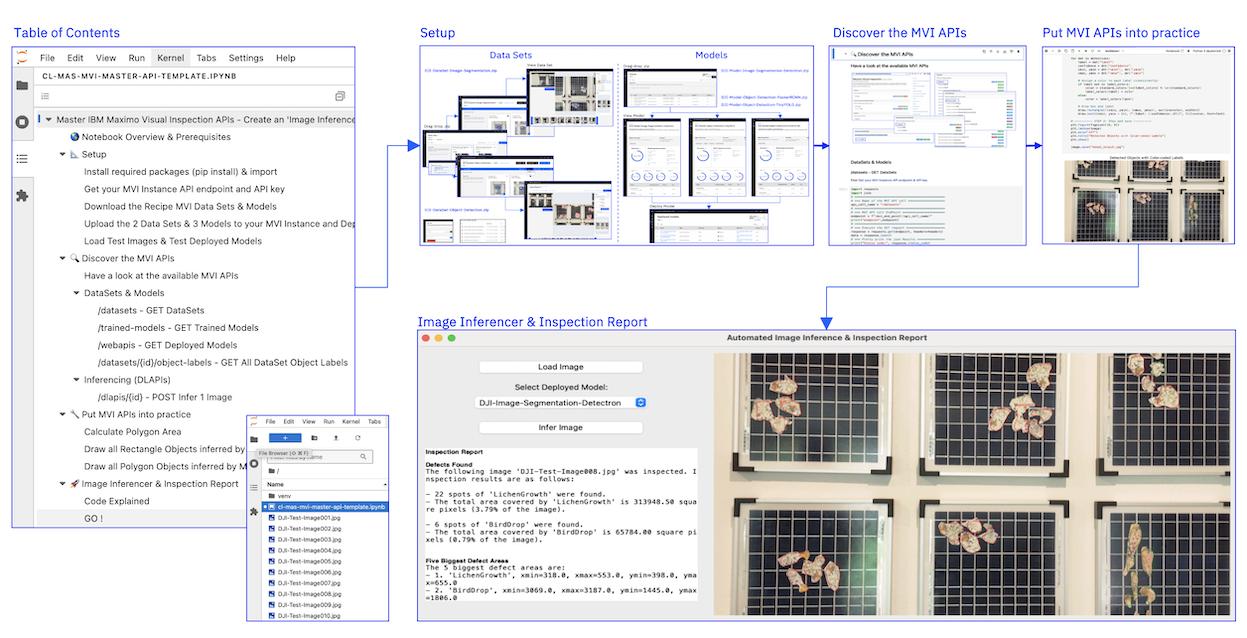

## 📐 Setup

In this section, you willl (1) import required python libraries, (2) get your MVI instance `API endpoint` and `API key`, (3) download & discover the recipe labeled data sets & trained models, then upload them to your MVI instance, (4) deploy the models to MVI and test them so they are ready to be used by all the recipe API calls.

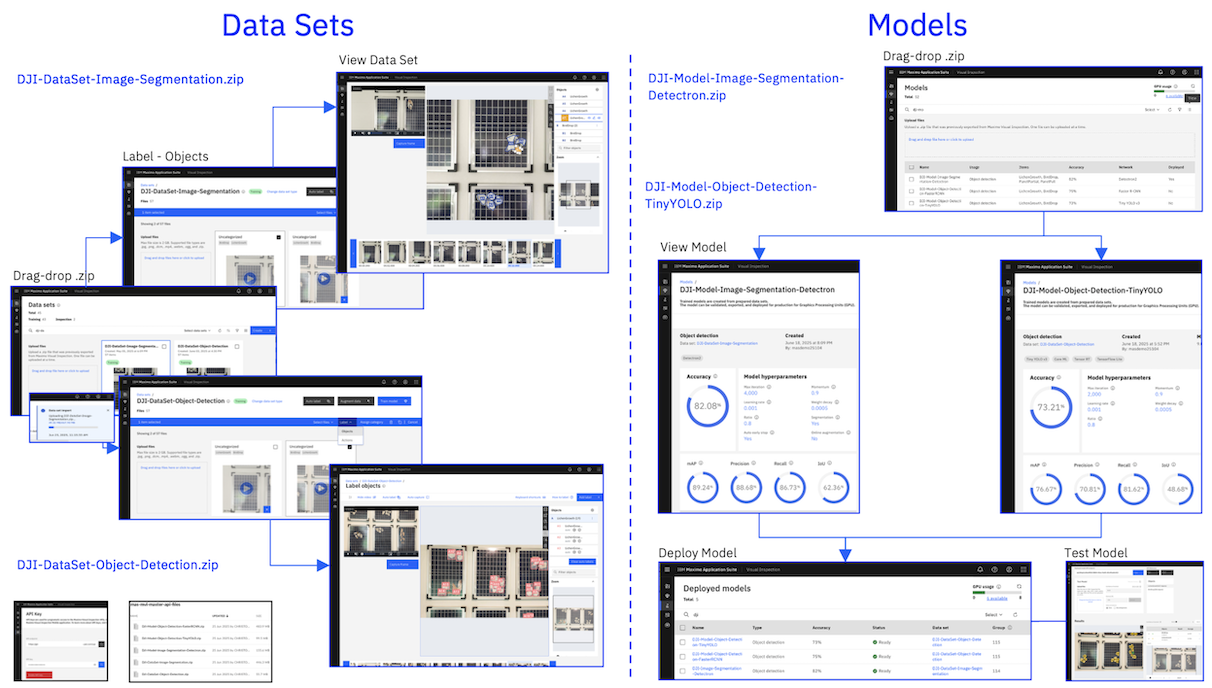

### Install required packages (pip install) & import 

This recipe uses standard <a href="https://docs.python.org/3/library/tkinter.html" target="_blank">tkinter</a>, `json` & `os` modules - which should be included by default in standard Python. <br> 
The only extra libraries required are: <a href="https://pypi.org/project/requests/" target="_blank">requests </a> and <a href="https://pypi.org/project/pillow/" target="_blank">PIL </a> (Python Imaging Library).<br>
Run this command to install both:

In [ ]:
pip install pillow requests

Check that this cell (which contains all imports that will be used) runs fine:

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk, ImageDraw, ImageFont
import requests
import json
import os

### Get your MVI Instance API endpoint and API key

From you MVI instance, go to the `Services` menu.

1. Copy and take note of the `API endpoint`. It should look like  `https://your-mvi-home-url/api` with `api` added at the end of your MVI home page.  Enter this value in the `your-mvi-api-end-point` cell below.
2. Copy and take note of the  `API key` if it exists. If not, click `Generate API key` button and copy the
`API key`. Enter this value in the `your-mvi-api-key` cell below.

In [ ]:
#================================================
# === Replace with your-mvi-api-key  ============
headers = {
    "x-auth-token": "your-mvi-api-key"
}
print("=== headers =", headers)
#================================================
# === Replace with your your-mvi-api-end-point ==
mvi_end_point = "https://your-mvi-api-end-point"
print("=== mvi_end_point =", mvi_end_point)
#================================================

### Download the Recipe MVI Data Sets & Models

Download the 5 .zip files available at this IBM Box folder link **<a href="https://ibm.ent.box.com/folder/326791711084?s=ehc2yflme5xf7qypabomk86beedyzn6b" target="_blank"> mas-mvi-master-api-files</a>**.<br> 
Here a description of each:<br>

| File Name | Description | Type | Size |
|:----------|:----------|:----------|:----------|
| **DJI-DataSet-Object-Detection.zip** | A zip file which, once imported into your MVI instance, will appear as 1 MVI Training Data Set containing 2 videos labeled with 569 occurences of `Lichen Growth` & 172 occurences of `BirdDrop` (labeling was done using *Rectangles*).<br><br> | Labeled Data Set | 56 MB |
| **DJI-DataSet-Image-Segmentation.zip** | A zip file which, once imported into your MVI instance, will appear as 1 MVI Training Data Set containing 2 videos labeled with 517 occurences of `Lichen Growth` & 204 occurences of `BirdDrop` (labeling was done using *Polygons*).<br><br> | Labeled Data Set | 446 MB |
| **DJI-Test-Images.zip** | 10 Images that can be used to test/run all the MVI API calls of this recipe. | Images for Testing | 5 MB |
| **DJI-Model-Object-Detection-TinyYOLO.zip** | A *ready-to-import-into-MVI* Trained TinyYOLO Model with 73.21% accuracy, 70.81% precision.<br> Trained using the above `DJI-DataSet-Object-Detection.zip` labeled Data Set.  | Trained Model (Object Detection) | 99 MB |
| **DJI-Model-Image-Segmentation-Detectron.zip** | A *ready-to-import-into-MVI* Trained Detectron2 Model with 82.08% accuracy, 88.68% precision. <br> Trained using the above `DJI-DataSet-Image-Segmentation.zip` labeled Data Set. | Trained Model (Image Segmetation)| 155 MB |

Unzip the `DJI-DataSet-Object-Detection.zip` file and have a look at its content:
1. the 2 x original DJI *.mp4 movies* (one 27 seconds long, the other 55).
2. ~55 .jpg images* corresponding to the images extracted from the movie (I used the 'Auto Capture' feature of MVI to extract those images).
3. ~55 correpsonding .xml files (each jpg has a corresponding xml with same name) which include the coordinates of the Rectangle labeled objects (type `Lichen Growth` or `BirdDrop`) on the given .jpg

Similarly, unzip the `DJI-DataSet-Image-Segmentation.zip` file and have a look at its content.

### Upload the 2 Data Sets & 3 Models to your MVI Instance and Deploy

From you MVI instance, go to the `Data sets` menu and:
1. Drag and drop the `DJI-DataSet-Object-Detection.zip` file (or click to upload) you just downloaded into the `Upload files` section. Wait for the heavy data set to be loaded and imported (see top-right progress indicator). 
2. Click on the imported `DJI-DataSet-Object-Detection` data set to open it in MVI. Observe that there are 2 movies. Tick the top-right box on 1 of the movie tile and select top-right `Label - Objects` - that will open the labeled movie.
3. Notice how below the movie itself, there are dozens of images. Click on 1 image then the other. Notice how, on each image, `LichenGrowth` and `BirdDrop` defects have been labeled using *rectangles*.

Repeat steps 1., 2., 3. above for `DJI-DataSet-Image-Segmentation.zip` and notice that instead of *rectangles*, we labeled with *polygons* here.

From you MVI instance, go to the `Models` menu and:
1. Drag and drop the `DJI-Model-Object-Detection-TinyYOLO.zip` file (or click to upload) from your Mac folder into the `Upload files` section. Wait for the heavy model to be loaded and imported (see top-right progress indicator).
2. Click on the imported `DJI-Model-Object-Detection-TinyYOLO.zip` model to open it in MVI. Observe its 

Repeat steps 1., 2. above for the `DJI-Model-Image-Segmentation-Detectron.zip` model.

### Load Test Images & Test Deployed Models

Unzip the `DJI-Test-Images.zip` file you just downloaded and drag and drop its 10 `DJI-Test-Image001.jpg` test images to the left window of this jupyter lab environment (`File Browser` view). These images will be used in next cells e.g. [/dlapis/{id} - POST Infer 1 Image](#dlapisid---post-infer-1-image).<br>

From you MVI instance, go to the `Deployed models` menu, open the `DJI-Model-Object-Detection-TinyYOLO` model, and drag and drop 1 of the test images on the `Test Model` box - observe how the model infers the image and returns detected defects. <br> Repeat with the `DJI-Model-Image-Segmentation-Detectron` model.

## 🔍 Discover the MVI APIs

### Have a look at the available MVI APIs

The MVI APIs are available via the <a href="https://www.ibm.com/docs/en/masv-and-l/maximo-vi/cd" target="_blank">
MVI Documentation</a> at the following link : <a href="https://public.dhe.ibm.com/systems/power/docs/powerai/api860.html" target="_blank">
IBM Maximo Visual Inspection REST APIS</a>.<br>
Have a detailed look at them. In this recipe, we will use APIs from the `DataSets`, `Deployed Models (WebAPIs)`, `TrainedModels` and `Inferencing (DLAPIs)` API groups.

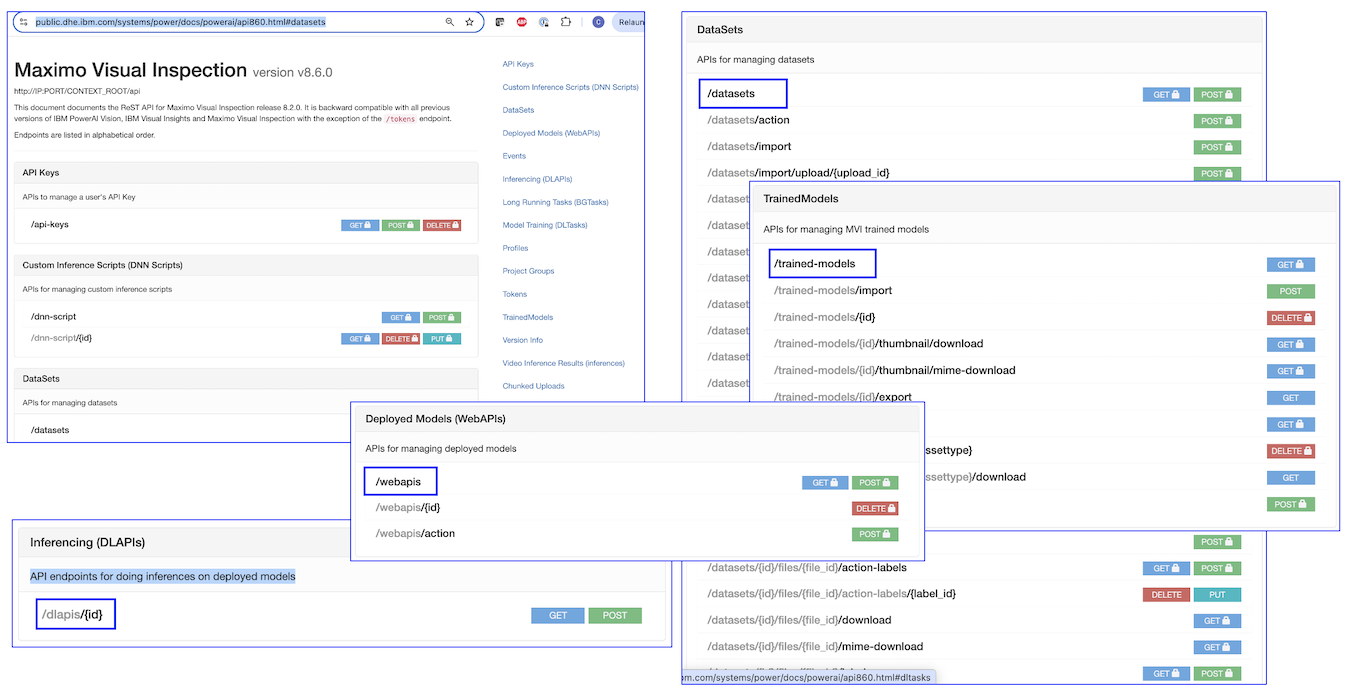

### DataSets & Models

#### /datasets - GET DataSets

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**MVI API Call Definition =** 
<a href="https://public.dhe.ibm.com/systems/power/docs/powerai/api860.html#datasets_get" target="_blank">GET /datasets</a>.<br>
**Parameters required :** none.<br>
**Output :** returns all data sets belonging to the user associated with provided "x-auth-token".<br>
**Your action :** Run below cell as-is and observe the output. Take note of the `_id` of both the `DJI-DataSet-Object-Detection` & `DJI-DataSet-Image-Segmentation` data sets - which you will use in future cells.

In [ ]:
import requests
import json
# =================================================
# === Name of the MVI API call ====================
api_call_name = "/datasets"
# =================================================
# === Build MVI API Call EndPoint =================
endpoint = f"{mvi_end_point}{api_call_name}"
print("=== API End Point =",endpoint)
# =================================================
# === Execute the API GET request =================
response = requests.get(endpoint, headers=headers)
data = response.json()
# === Print the Response  =========================
print("=== Status code =", response.status_code)
data = response.json()
print("=== Response Body =", json.dumps(data, indent=2))
# =================================================

Sample successful Response Body (200 OK):
```json
[
{
    "_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc",
    "name": "DJI-DataSet-Object-Detection",
    "usage": "generic",
    "type": null,
    "purpose": "training",
    "scenario": "",
    "pre_process": "",
    "owner": "yourself",
    "locked": 0,
    "total_file_count": 57,
    "thumbnail_path": "Deprecated; use GET 'datasets/{datasetId}/thumbnail/download",
    "created_at": 1748939400979,
    "updated_at": 1750760039759
  },
  {
    "_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8",
    "name": "DJI-DataSet-Image-Segmentation",
    "usage": "generic",
    "type": null,
    "purpose": "training",
    "scenario": "",
    "pre_process": "",
    "owner": "yourself",
    "locked": 0,
    "total_file_count": 57,
    "thumbnail_path": "Deprecated; use GET 'datasets/{datasetId}/thumbnail/download",
    "created_at": 1746439779092,
    "updated_at": 1750760057921
  }
]  
```

#### /trained-models - GET Trained Models

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**MVI API Call Definition =** 
<a href="https://public.dhe.ibm.com/systems/power/docs/powerai/api860.html#trained_models_get" target="_blank">GET /trained-models</a>.<br>
**Parameters required:** none.<br>
**Output:** returns all MVI trained models belonging to the user associated with provided "x-auth-token".<br>
**Your action:** Just run below cell as-is and observe the output.  

In [ ]:
import requests
import json

# =================================================
# === Name of MVI API call ========================
api_call_name = "/trained-models"
# =================================================
# === Build MVI API Call EndPoint =================
# endpoint = f"{server_url}{api_call_name}"
endpoint = f"{mvi_end_point}/{api_call_name}"
print("=== API End Point =", endpoint)
# =================================================
# === Execute the API GET request =================
response = requests.get(endpoint, headers=headers)
data = response.json()
# === Print the Response  =========================
print("=== Status code =", response.status_code)
print("=== Response Body =", json.dumps(data, indent=2))
# =================================================

Sample successful Response Body (200 OK):
```json
[
    {
    "_id": "a0aef05d-8804-45ea-9ed5-d5c49aa0c413",
    "name": "DJI-Model-Image-Segmentation-Detectron",
    "dataset_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8",
    "usage": "cod",
    "nn_arch": "mrcnn",
    "userdnn_id": null,
    "method": "FineTuning",
    "strategy": {
      "max_iter": "4000",
      "momentum": "0.9",
      "learning_rate": "0.001",
      "weight_decay": "0.0005",
      "ratio": 0.8,
      "segmentation_flag": "1",
      "autoearlystop_flag": "1",
      "online_augmentation_flag": "0"
    },
    "dataset_summary": {
      "image_count": 54,
      "class_count": 2,
      "class_list": [
        {
          "name": "LichenGrowth",
          "label_count": 517,
          "image_count": 43
        },
        {
          "name": "BirdDrop",
          "label_count": 204,
          "image_count": 53
        }
      ]
    },
    "production_status": "untested",
    "categories": [
      {
        "category_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8-lichengrowth",
        "category_name": "LichenGrowth"
      },
      {
        "category_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8-birddrop",
        "category_name": "BirdDrop"
      },
      {
        "category_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8-panelpartial",
        "category_name": "PanelPartial"
      },
      {
        "category_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8-panelfull",
        "category_name": "PanelFull"
      }
    ],
    "owner": "yourself",
    "deployed": 1,
    "type": 0,
    "eval_data": {
      "type": "test_msg",
      "precision_recall": [
        {
          "recall": [
            "0.02",
            "0.10",
            "0.20",
            "0.32",
            "0.40",
            "0.50",
            "0.62",
            "0.72",
            "0.80",
            "0.90",
            "1.00"
          ],
          "precision": [
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "0.96",
            "0.96",
            "0.83"
          ],
          "class_id": "LichenGrowth",
          "confusion_matrix": [
            0.9508196721311475,
            0.01639344262295082
          ]
        },
        {
          "recall": [
            "0.03",
            "0.11",
            "0.22",
            "0.31",
            "0.42",
            "0.50",
            "0.61",
            "0.72",
            "0.81"
          ],
          "precision": [
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "1.00",
            "0.96",
            "0.85"
          ],
          "class_id": "BirdDrop",
          "confusion_matrix": [
            0.02702702702702703,
            0.7837837837837838
          ]
        }
      ],
      "mAP_cls": "0.89244",
      "mAP_attr": "0.00000",
      "IoU_value": "0.62357",
      "class_summary": [
        {
          "class_id": "LichenGrowth",
          "data": {
            "recall": 1.0,
            "accuracy": "0.97847",
            "precision": "0.97847",
            "iou": 0.6557585660101032
          }
        },
        {
          "class_id": "BirdDrop",
          "data": {
            "recall": 0.8333333333333334,
            "accuracy": "0.80157",
            "precision": "0.80157",
            "iou": 0.5913782008406219
          }
        }
      ],
      "avg_accuracy": 0.8207547169811321,
      "avg_recall": 0.8673017279574656,
      "avg_precision": 0.8867880485527544,
      "timestamp": "2025-06-18T12:09:02",
      "callback": {
        "msgState": "training",
        "msgReturnCode": "InProgress",
        "msgDesc": "None"
      }
    },
    "accuracy": "0.8207547169811321",
    "thumbnail_path": "/opt/powerai-vision/data/yourself/trained-models/thumbnails/a0aef05d-8804-45ea-9ed5-d5c49aa0c413.jpg",
    "created_at": 1750248544973,
    "version": "9.0.5",
    "project_group_id": "c573697f-c06d-418c-83a9-80caa06b6a6f",
    "project_group_name": "DJI-SolarPanel-Project",
    "updated_at": 1751329594360
  },
  {...
  }    
]
```


#### /webapis - GET Deployed Models

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**MVI API Call Definition:** 
<a href="https://public.dhe.ibm.com/systems/power/docs/powerai/api860.html#webapis_get" target="_blank">GET /webapis</a>.<br>
**Parameters required:** none.<br>
**Output:** returns all MVI deployed models belonging to the user associated with provided "x-auth-token".<br>
**Your action:** Run below cell as-is and observe the output. Take note of the `_id` of both the `DJI-Model-Object-Detection-TinyYOLO` & `DJI-Model-Image-Segmentation-Detectron` models - which you will use in next cells.

In [ ]:
import requests
import json

# =================================================
# === Name of MVI API call ========================
api_call_name = "/webapis"
# =================================================
# === Build MVI API Call EndPoint =================
endpoint = f"{mvi_end_point}/{api_call_name}"
print("API End Point:", endpoint)
# =================================================
# === Execute the API GET request =================
response = requests.get(endpoint, headers=headers)
data = response.json()
# =================================================
# === Print the Response ==========================
print("Status code:", response.status_code)
try:
    data = response.json()
    print("Response Body", json.dumps(data, indent=2))
except json.JSONDecodeError:
    print("Response Body is not valid JSON.")
# =================================================
# print("Response Body", json.dumps(data, indent=2))
# =================================================

Sample successful Response Body (200 OK):

```json
[
  {
    "_id": "7bd667ae-4bae-44f4-905f-f7fb7681ef53",
    "owner": "yourself",
    "usage": "cod",
    "replicas": 1,
    "name": "DJI-Model-Object-Detection-TinyYOLO",
    "created_at": 1751417409260,
    "userdnn_id": null,
    "dnnscript_id": null,
    "save_inference": null,
    "accuracy": "0.7321428571428571",
    "categories": [
      {
        "category_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc-lichengrowth",
        "category_name": "LichenGrowth"
      },
      {
        "category_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc-birddrop",
        "category_name": "BirdDrop"
      }
    ],
    "status": "ready",
    "nn_arch": "tiny_yolo_v3",
    "project_group_id": "c573697f-c06d-418c-83a9-80caa06b6a6f",
    "project_group_name": "DJI-SolarPanel-Project",
    "production_status": "untested",
    "version": "9.0.5",
    "dataset_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc",
    "accel_type": "GPU",
    "container_id": "f7610e6c-9c1d-4a96-890d-f53475b9f8d6",
    "shareable_container": "DLE",
    "group_id": 114
  },
  {
    "_id": "a0aef05d-8804-45ea-9ed5-d5c49aa0c413",
    "owner": "yourself",
    "usage": "cod",
    "replicas": 1,
    "name": "DJI-Model-Image-Segmentation-Detectron",
    "created_at": 1751368849762,
    "userdnn_id": null,
    "dnnscript_id": null,
    "save_inference": null,
    "accuracy": "0.8207547169811321",
    "categories": [
      {
        "category_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8-lichengrowth",
        "category_name": "LichenGrowth"
      },
      {
        "category_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8-birddrop",
        "category_name": "BirdDrop"
      }
    ],
    "status": "ready",
    "nn_arch": "mrcnn",
    "project_group_id": "c573697f-c06d-418c-83a9-80caa06b6a6f",
    "project_group_name": "DJI-SolarPanel-Project",
    "production_status": "untested",
    "version": "9.0.5",
    "dataset_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8",
    "accel_type": "GPU",
    "container_id": "f7610e6c-9c1d-4a96-890d-f53475b9f8d6",
    "shareable_container": "DLE",
    "group_id": 114
  }
]
```


#### /datasets/{id}/object-labels - GET All DataSet Object Labels

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**MVI API Call Definition =** 
<a href="https://public.dhe.ibm.com/systems/power/docs/powerai/api860.html#datasets__id__object_labels_get" target="_blank"> GET /datasets/{id}/object-labels</a>.<br>
**Parameters required:** `dataset_id`.<br>
**Output:** returns object labels for all images in the given data set. Note that in the below cell, onlythe first 3 entries are returned.<br>
**Your action:** Enter the  the `_id` of the `DJI-DataSet-Image-Segmentation` data set (that you noted in [/datasets - GET DataSets](#datasets---get-datasets) previous cell) into `dataset_id` in the cell below . Then run the cell and observe the json output, especially the `"segment_polygons"` parts which contain the coordinates of all points of all *polygons* detected.<br><br> 
Repeat above steps but replace the `dataset_id` with `_id` of the `DJI-DataSet-Object-Detection` data set. Then run the cell and observe the json output, especially the `"bndbox"` parts which contain the coordinates of all *rectangles* detected (xmin, xmax, ymin, ymax).

In [ ]:
import requests
import json

# ==============================================================
# === Extract dataset ID from prior call =======================
dataset_id = "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8"
# ==============================================================
# === Name of new API call =====================================
api_call_name = f"/datasets/{dataset_id}/object-labels"
# ==============================================================
# === Build MVI API Call EndPoint ==============================
# endpoint = f"{server_url}{api_call_name}"
endpoint = f"{mvi_end_point}{api_call_name}"
print("=== API End Point =", endpoint)
# ==============================================================
# === Execute the GET request ==================================
response = requests.get(endpoint, headers=headers)
data_categories = response.json()
# ==============================================================
# === Pretty print the JSON Results ============================
print("=== Status code =", response.status_code)
print("=== Number of defects found =", len(data_categories))
data_categories = response.json()
# === Print only the first 3 entries ===========================
print("=== First 3 results only =")
print(json.dumps(data_categories[:3], indent=2))  # safe preview
# === Uncomment below line to see all results  =================
# print("Response Body", json.dumps(data_categories, indent=2))

Sample successful Response Body (200 OK):
1. For `DJI-DataSet-Object-Detection`

```json
[
  {
    "_id": "eb2aa6a5-33c5-4c21-aba4-57d4f8c6a834",
    "dataset_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc",
    "file_id": "705d719d-e1bc-4d1c-94bc-b4cb7e57dc76",
    "tag_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc-lichengrowth",
    "name": "LichenGrowth",
    "generate_type": "manual",
    "bndbox": {
      "xmin": 243,
      "ymin": 547,
      "xmax": 365,
      "ymax": 600
    }
  },
  {
    "_id": "3014d7a3-f463-40b9-9da8-694f591834e0",
    "dataset_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc",
    "file_id": "705d719d-e1bc-4d1c-94bc-b4cb7e57dc76",
    "tag_id": "c9fbc996-87fc-4c63-b5e0-36c8c78bc6fc-lichengrowth",
    "name": "LichenGrowth",
    "generate_type": "manual",
    "bndbox": {
      "xmin": 269,
      "ymin": 616,
      "xmax": 354,
      "ymax": 729
    }
]
```

2. For `DJI-DataSet-Object-Detection`
```json
[
  {
    "_id": "4660ee8f-3949-4336-b6e6-bc017dc5090d",
    "dataset_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8",
    "file_id": "00ad62a4-a505-424e-9ba1-7eb5d3daa163",
    "tag_id": "f6768fa2-d0b4-4c27-a8a3-71ef8abe9fe8-lichengrowth",
    "name": "LichenGrowth",
    "generate_type": "manual",
    "segment_polygons": [
      [
        [
          577,
          1123
        ],
        [
          500,
          1171
        ],
        [
          518,
          1209
        ]
      ],
    "bndbox": {
      "xmin": 500,
      "ymin": 1106,
      "xmax": 729,
      "ymax": 1225
    }
  }
]  
```


### Inferencing (DLAPIs)

#### /dlapis/{id} - POST Infer 1 Image

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**MVI API Call Definition =** 
<a href="https://public.dhe.ibm.com/systems/power/docs/powerai/api860.html#dlapis__id__post" target="_blank"> POST /dlapis/{id}</a>.<br>
**Parameters required:** `model_id` & 1 `image`.<br>
**Output:** returns the results of an inference run on an uploaded image.<br>
**Your action:** In `"files"` section in cell below, leave or replace `"DJI-Test-Image001.jpg"` by any 1 of the 10 images you want to infer (cf. [Load Test Images & Test Deployed Models](#load-test-images--test-deployed-models)). <br> 
Enter the  the `_id` of the `DJI-Model-Image-Segmentation-Detectron` model (that you noted in [/webapis - GET Deployed Models](#webapis---get-deployed-models) previous cell) into `model_id` in the cell below . Then run the cell and observe the json output, especially the `"segment_polygons"` parts which contain the coordinates of all points of all *polygons* detected.<br><br> 
Repeat above steps but replace the `model_id` with `_id` of the `DJI-Model-Object-Detection-TinyYOLO` model. Then run the cell and observe the json output, especially the `"bndbox"` parts which contain the coordinates (xmin, ymin, xmax, ymax) of all *rectangles* detected.

In [ ]:
import requests
import json

# ===============================================================
# === Enter your Model ID here ==================================
model_id = "a0aef05d-8804-45ea-9ed5-d5c49aa0c413"
# ===============================================================
# === Build MVI API Call EndPoint ===============================
api_call_name = f"/dlapis/{model_id}"
endpoint = f"{mvi_end_point}/{api_call_name}"
print("=== API End Point =", endpoint)
# ===============================================================
# === Enter name of image to infer here =========================
files = {
    "files": open("DJI-Test-Image001.jpg", "rb")
}
# ===============================================================
# === Execute the API POST request ==============================
response = requests.post(endpoint, headers=headers, files=files)
# ===============================================================
# === Print the Response ========================================
print("=== Status code =", response.status_code)
if response.ok:
    parsed = response.json()
    print(json.dumps(parsed, indent=4))
else:
    print("Error:", response.status_code, response.text)
# === Close image file ==========================================
files["files"].close()
# ===============================================================

Sample RECTANGLE (`DJI-Model-Object-Detection-TinyYOLO` model) Output:
```json
{
    "webAPIId": "7bd667ae-4bae-44f4-905f-f7fb7681ef53",
    "imageUrl": "https://your-mvi:39443/your-mvi-api/uploads/temp/7bd667ae-4bae-44f4-905f-f7fb7681ef53/0d1ca74f-fe4f-4b13-8c94-890a37689786.jpg",
    "classified": [
        {
            "label": "LichenGrowth",
            "confidence": 0.9959121346473694,
            "xmin": 1549,
            "ymin": 194,
            "xmax": 1638,
            "ymax": 294
        },
        {
            "label": "BirdDrop",
            "confidence": 0.8650818467140198,
            "xmin": 3005,
            "ymin": 1562,
            "xmax": 3082,
            "ymax": 1745
        }
    ],
    "result": "success",
    "saveInferenceResults": null
}
    
```
<br>

Sample POLYGON (`DJI-Model-Image-Segmentation-Detectron` model) Output:

```json
{
    "webAPIId": "a0aef05d-8804-45ea-9ed5-d5c49aa0c413",
    "imageUrl": "https://your-mvi:39443/your-mvi-api/uploads/temp/a0aef05d-8804-45ea-9ed5-d5c49aa0c413/b9d750bb-ab5f-4829-bcc1-9cb1e225bea6.jpg",
    "classified": [
        {
            "label": "LichenGrowth",
            "confidence": 0.9994040727615356,
            "xmin": 324,
            "ymin": 27,
            "xmax": 629,
            "ymax": 233,
            "polygons": [
                [
                    [
                        345,
                        29
                    ],
                    [
                        344,
                        30
                    ],
                    [
                        338,
                        30
                    ],
                    [
                        337,
                        31
                    ],
                    [
                        ...
                    ]
                ]
            ]
        },                    
```

## 🔧 Put MVI APIs into practice

### Calculate Polygon Area

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**Cell Definition =** This cell defines a function `polygon_area(points)` which is called on an infered image and calculates the area of each polygon detected and the total area.<br>
**Parameters required:** `model_id` & `image`.<br>
**Output:** List of all *Polygons* detected on a given image with name of their Label & Area +  Total Area of all polygons in px².<br>
**Your action:** In `"files"` section in cell below, leave or replace `"DJI-Test-Image001.jpg"` by any 1 of the 10 images you want to infer (cf. [Load Test Images & Test Deployed Models](#load-test-images--test-deployed-models)). <br> 
Enter the  the `_id` of the `DJI-Model-Image-Segmentation-Detectron` model (that you noted in [/webapis - GET Deployed Models](#webapis---get-deployed-models) previous cell) into `model_id` in the cell below. Then run the cell and read the output.

In [ ]:
import json

# =================================================
# === Calculate polygon area function =============
def polygon_area(points):
    n = len(points)
    return 0.5 * abs(
        sum(points[i][0] * points[(i + 1) % n][1] - points[(i + 1) % n][0] * points[i][1]
            for i in range(n))
    )
# =================================================

# === Enter your Model ID here ====================
model_id = "a0aef05d-8804-45ea-9ed5-d5c49aa0c413"
# =================================================
# === Build MVI API Call EndPoint =================
api_call_name = f"/dlapis/{model_id}"
endpoint = f"{mvi_end_point}/{api_call_name}"
# =================================================
# === Enter name of image to infer here ===========
files = {
    "files": open("DJI-Test-Image005.jpg", "rb")
}
# =================================================
# === Execute the API POST request ================
response = requests.post(endpoint, headers=headers, files=files)

# =================================================    
# === Calculate area of each and all Polygons =====
# =================================================
if response.ok:
    parsed = response.json()  
    total_area = 0  # Initialize total area
    print("=== The following polygons were detected =")
    # === Extract and compute areas ================
    for j, obj in enumerate(parsed.get("classified", [])):
        label = obj.get("label", "Unknown")
        for i, polygon in enumerate(obj.get("polygons", [])):
            area = polygon_area(polygon)
            total_area += area  # Accumulate area
            print(f"Polygon {j} | Label = {label} | Polygon Area = {area:.2f} px²")
    print(f"\n === Total area of all polygons = {total_area:.2f} px²")

else:
    print("Error:", response.status_code, response.text)
# === Close image file ====================
files["files"].close()
# =========================================    

Sample successful output:
```python
=== The following polygons were detected =
Polygon 0 | Label = LichenGrowth | Polygon Area = 23973.50 px²
Polygon 1 | Label = LichenGrowth | Polygon Area = 16124.00 px²
Polygon 2 | Label = BirdDrop     | Polygon Area = 12434.00 px²
Polygon 3 | Label = LichenGrowth | Polygon Area = 18013.50 px²
=== Total area of all Polygons = 281918.00 px²
```

### Draw all Rectangle Objects inferred by MVI (Object Detection)

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**Cell Definition =** this cell infers an image, then draws *Rectangles* around the detected objects, labels them with their confidence scores, and displays the resulting image.<br>
**Parameters required:** `model_id` & `image`.<br>
**Output:** 1 image annotated with *Rectangles*.<br>
**Your action:** In `"files"` section in cell below, leave or replace `"DJI-Test-Image001.jpg"` by any 1 of the 10 images you want to infer (cf. [Load Test Images & Test Deployed Models](#load-test-images--test-deployed-models)). <br> 
Enter the  the `_id` of the `DJI-Model-Object-Detection-TinyYOLO` model (that you noted in [/webapis - GET Deployed Models](#webapis---get-deployed-models) previous cell) into `model_id` in the cell below. Then run the cell and observe the ouptut (i.e. 1 image annotated with *rectangles*). 

In [ ]:
import requests
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# =================================================
# === Enter name of image to infer here ===========
image_path = "DJI-Test-Image001.jpg"
files = {
    "files": open(image_path, "rb")
}
# =================================================
# === Enter your Model ID here ====================
model_id = "7bd667ae-4bae-44f4-905f-f7fb7681ef53"
# === Build MVI API Call EndPoint =================
api_call_name = f"/dlapis/{model_id}"
endpoint = f"{mvi_end_point}/{api_call_name}"
# === Execute the API POST request ================
response = requests.post(endpoint, headers=headers, files=files)
# =================================================

# =================================================
# === Draw rectangles =============================
if response.status_code != 200:
    print("Error:", response.status_code, response.text)
else:
    data = response.json()
    detections = data.get("classified", [])

    # === Set up colors ===========================
    standard_colors = [
        "red", "green", "blue", "orange", "purple", "brown", "cyan", "magenta", "yellow", "lime"
    ]
    label_colors = {}  # Maps label -> color
    # === Open Image & Draw =======================
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()
    # === Draw each Rectangle ======================
    for det in detections:
        label = det["label"]
        confidence = det["confidence"]
        xmin, ymin = det["xmin"], det["ymin"]
        xmax, ymax = det["xmax"], det["ymax"]

        # === Assign a color to each label ========
        if label not in label_colors:
            color = standard_colors[len(label_colors) % len(standard_colors)]
            label_colors[label] = color
        else:
            color = label_colors[label]

        # === Draw box and label ==================
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=color, width=3)
        draw.text((xmin, ymin - 15), f"{label} ({confidence:.2f})", fill=color, font=font)

    # ======== Show and save =======================
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Detected Rectangle Objects")
    plt.show()
    
    # Uncomment below line of you want to save the image
    # image.save("boxed_output.jpg")


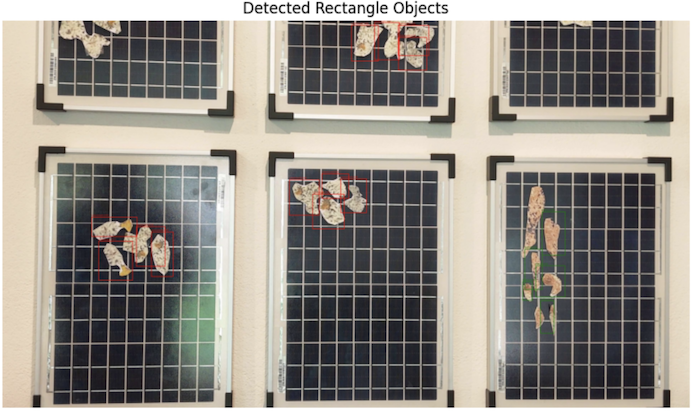

### Draw all Polygon Objects inferred by MVI (Image Segmentation)

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br>

**Cell Definition =** this cell infers an image, then draws *Polygons* around the detected objects, labels them with their confidence scores, and displays the resulting image.<br>
**Parameters required:** `model_id` & `image`.<br>
**Output:** 1 image annotated with *Polygons*.<br>
**Your action:** In `"files"` section in cell below, leave or replace `"DJI-Test-Image001.jpg"` by any 1 of the 10 images you want to infer (cf. [Load Test Images & Test Deployed Models](#load-test-images--test-deployed-models)). <br> 
Enter the  the `_id` of the `DJI-Model-Image-Segmentation-Detectron` model (that you noted in [/webapis - GET Deployed Models](#webapis---get-deployed-models) previous cell) into `model_id` in the cell below. Then run the cell and observe the ouptut (i.e. 1 image annotated with *rectangles*). 

In [ ]:
import requests
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt


# =================================================
# === Enter name of image to infer here ===========
image_path = "DJI-Test-Image005.jpg"
files = {
    "files": open(image_path, "rb")
}
# =================================================
# === Enter your Model ID here ====================
model_id = "a0aef05d-8804-45ea-9ed5-d5c49aa0c413"
# === Build MVI API Call EndPoint =================
api_call_name = f"/dlapis/{model_id}"
endpoint = f"{mvi_end_point}/{api_call_name}"
# === Execute the API POST request ================
response = requests.post(endpoint, headers=headers, files=files)
# =================================================

# =================================================
# === Draw Polygons ===============================
if response.status_code != 200:
    print("Error:", response.status_code, response.text)
else:
    data = response.json()
    detections = data.get("classified", [])

    # =============================================
    # === Set up drawing ==========================
    standard_colors = [
        "red", "green", "blue", "orange", "purple", "brown",
        "cyan", "magenta", "yellow", "lime"
    ]
    label_colors = {}
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 32)
    except:
        font = ImageFont.load_default()

    for det in detections:
        label = det.get("label", "Unknown")
        confidence = det.get("confidence", 0.0)
        polygons = det.get("polygons", [])

        # ==========================================
        # === Assign color per label ===============
        if label not in label_colors:
            color = standard_colors[len(label_colors) % len(standard_colors)]
            label_colors[label] = color
        else:
            color = label_colors[label]
        # =================================
        # === Draw Polygons ===============
        for polygon in polygons:
            # === Convert polygon list to flat tuple list for drawing ===
            if isinstance(polygon, list) and all(isinstance(p, list) and len(p) == 2 for p in polygon):
                points = [tuple(p) for p in polygon]
                draw.polygon(points, outline=color, width=6)
                
                # === Draw label text near first point ===================
                x_text, y_text = points[0]
                draw.text((x_text, y_text - 15), f"{label} ({confidence:.2f})", fill=color, font=font)

    # === Show and Save ==================================================
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Detected Objects with Polygons")
    plt.show()
   # Uncomment below line of you want to save the image
   # image.save("polygon_output.jpg")


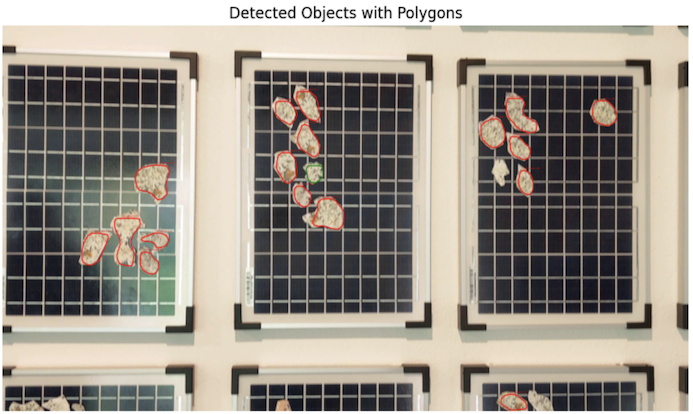

## 🚀 Image Inferencer & Inspection Report

### GO !

Make sure you have run this [Get your MVI Instance API endpoint & API key](##get-your-mvi-instance-api-endpoint--api-key) cell prior to running below one.<br><br>
**Description:** Below cell code is a <a href="https://docs.python.org/3/library/tkinter.html" target="_blank">tkinter </a> GUI application which allows you to load an image, select an MVI deployed model to perform an inference on it, display the annotated inspected image, and present a summary report of detected objects and their areas within the image.<br>
Key functions include:
- `load_models()`: Loads available deployed models from your MVI instance and populates a dropdown menu for model selection.<br>
- `load_image()`: opens a file dialog to load an image and displays it in the GUI.<br>
- `polygon_area()` and `rectangle_area()`: functions to calculate areas of polygons and rectangles, respectively.<br>
- `infer_image()`: Performs inference on the selected image using the chosen model, displaying detected objects with their labels, confidence scores, and areas, and presenting a summary in the text area below.<br>

**Parameters required:** none.<br>
**Output:** This cell will launch a GUI app outside of your browser.<br>

**Your action:** Just run this cell ... and play with the GUI opened outdside of your browser i.e.:
1. Click `Load Image` button and select 1 of your test images (cf. [Load Test Images & Test Deployed Models](#load-test-images--test-deployed-models)). This will load and display the image on the right panel.
2. Select 1 model in `Select deployed model`. 
3. Click `Infer Image`. Observe both the returned annotated image (right panel) and the inspection report (left panel)
4. Repeat 1. and 2. with different images and models.

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk, ImageDraw, ImageFont
import requests
import json
import os

# ==========================================================
# === Main App Window ======================================
root = tk.Tk()
root.title("Automated Image Inference & Inspection Report")
# ==========================================================

# ========================================================
# === Global State Variables =============================
image_path = None          # Path to current loaded image
original_image = None      # Original image 
model_options = {}         # Mapping of model names to IDs
selected_model_name = tk.StringVar()
selected_model_name.set("Fetching...")
# ========================================================

# ========================================================
# === Use headers and mvi_end_point
# ========================================================
try:
    _ = headers["x-auth-token"]
    _ = mvi_end_point

except Exception as e:
    raise RuntimeError("Please run the config cell first to define headers and mvi_end_point.") from e

# ========================================================
# === Fetch available deployed models from API ===========
# ========================================================
def load_models():
    try:
        # ================================================
        # === MVI API Call to /webapis ===================
        response = requests.get(f"{mvi_end_point}/webapis", headers=headers)
        if response.ok:
            models = response.json()
            model_options.clear()

            # === Clear and populate the dropdown menu
            menu = model_menu["menu"]
            menu.delete(0, "end")
            for model in models:
                if model.get("status") == "ready":
                    name = model.get("name")
                    mid = model.get("_id")
                    if name and mid:
                        model_options[name] = mid
                        menu.add_command(label=name, command=tk._setit(selected_model_name, name))
            
            # === Set the first model as default
            if model_options:
                selected_model_name.set(list(model_options.keys())[0])
            else:
                selected_model_name.set("No Ready Models")
        else:
            selected_model_name.set("Error loading models")
            print("Error:", response.status_code, response.text)
    except Exception as e:
        selected_model_name.set("Exception occurred")
        print("Exception:", str(e))

# ===========================================
# === Load and display a local image file ===
# ===========================================
def load_image():
    global image_path, original_image
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if file_path:
        image_path = file_path
        try:
            original_image = Image.open(file_path).convert("RGB")
            img_display = original_image.copy()
            img_display.thumbnail((800, 600))  # Resize for display
            img_tk = ImageTk.PhotoImage(img_display)
            image_label.configure(image=img_tk)
            image_label.image = img_tk

            # === Show filename in summary panel
            summary_text.delete("1.0", tk.END)
            summary_text.insert(tk.END, f"Image loaded: {os.path.basename(file_path)}\n")
        except Exception as e:
            messagebox.showerror("Image Error", f"Could not load image:\n{str(e)}")

# ==============================================================
# === Calculate area of a polygon ==============================
# ==============================================================
def polygon_area(poly):
    area = 0.0
    if len(poly) < 3:
        return 0.0
    for i in range(len(poly)):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % len(poly)]
        area += (x1 * y2 - x2 * y1)
    return abs(area) / 2.0

# ==============================================================
# === Calculate area of rectangle ==============================
# ==============================================================
def rectangle_area(rect):
    return abs((rect[2] - rect[0]) * (rect[3] - rect[1]))

# ==============================================================
# === Send image to model endpoint and annotate results ========
# ==============================================================
def infer_image():
    global image_path, original_image
    if not image_path:
        messagebox.showwarning("No Image", "Please load an image first.")
        return

    model_name = selected_model_name.get()
    if model_name not in model_options:
        messagebox.showwarning("Model Error", "Please select a deployed model.")
        return

    # === Prepare API endpoint for selected model
    dlapi_id = model_options[model_name]
    # ===========================================================
    # === MVI API Call to /dlapis/{dlapi_id} for Inference ======
    endpoint = f"{mvi_end_point}/dlapis/{dlapi_id}"

    try:
        # === Upload image to inference API ======
        with open(image_path, "rb") as img_file:
            files = {"files": img_file}
            response = requests.post(endpoint, headers=headers, files=files)

        if not response.ok:
            summary_text.delete("1.0", tk.END)
            summary_text.insert(tk.END, f"Error: {response.status_code}\n{response.text}")
            return

        # === Parse detection output ===========
        parsed = response.json()
        detections = parsed.get("classified", [])

        # === Load original image and prepare drawing context ==
        original_image = Image.open(image_path).convert("RGB")
        image = original_image.copy()
        draw = ImageDraw.Draw(image)
        try:
            font = ImageFont.truetype("arial.ttf", 20)
        except:
            font = ImageFont.load_default()

        # === Assign unique colors to labels ======================
        standard_colors = ["red", "green", "blue", "orange", "purple", "cyan", "magenta", "yellow"]
        label_colors = {}
        label_counts = {}
        label_areas = {}

        # === Draw all detections =================================
        for det in detections:
            label = det.get("label", "Unknown")
            conf = det.get("confidence", 0.0)
            polygons = det.get("polygons", [])

            # === Assign color to label ============================
            color = label_colors.setdefault(label, standard_colors[len(label_colors) % len(standard_colors)])

            # === Draw polygon detections ==========================
            if polygons:
                for poly in polygons:
                    if isinstance(poly, list) and all(isinstance(p, list) and len(p) == 2 for p in poly):
                        pts = [tuple(p) for p in poly]
                        draw.polygon(pts, outline=color, width=3)
                        draw.text((pts[0][0], pts[0][1]-15), f"{label} ({conf:.2f})", fill=color, font=font)
                        label_counts[label] = label_counts.get(label, 0) + 1
                        label_areas[label] = label_areas.get(label, 0.0) + polygon_area(pts)
            else:
                # Draw rectangular detections
                xmin, ymin, xmax, ymax = det.get("xmin"), det.get("ymin"), det.get("xmax"), det.get("ymax")
                if None not in [xmin, ymin, xmax, ymax]:
                    draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)
                    draw.text((xmin, ymin - 15), f"{label} ({conf:.2f})", fill=color, font=font)
                    label_counts[label] = label_counts.get(label, 0) + 1
                    label_areas[label] = label_areas.get(label, 0.0) + rectangle_area((xmin, ymin, xmax, ymax))

        # === Display image with detections ===
        img_display = image.copy()
        img_display.thumbnail((800, 600))
        img_tk = ImageTk.PhotoImage(img_display)
        image_label.configure(image=img_tk)
        image_label.image = img_tk
        original_image = image.copy()  # Keep modified version for future use if needed

        # === Get total image area for percent coverage ===
        width, height = original_image.size
        total_image_area = width * height

        # === Build summary report ===
        fname = os.path.basename(image_path)
        summary_lines = [f"The following image '{fname}' was inspected. Inspection results are as follows:\n"]
        for label in label_counts:
            count = label_counts[label]
            area = label_areas[label]
            ratio = (area / total_image_area) * 100
            summary_lines.append(f"- {count} spots of '{label}' were found.")
            summary_lines.append(f"- The total area covered by '{label}' is {area:.2f} square pixels ({ratio:.2f}% of the image).\n")

        # === Top 5 biggest defect boxes ===
        boxes = []
        for det in detections:
            label = det.get("label", "Unknown")
            polygons = det.get("polygons", [])
            if polygons:
                for poly in polygons:
                    if isinstance(poly, list) and all(isinstance(p, list) and len(p) == 2 for p in poly):
                        area = polygon_area([tuple(p) for p in poly])
                        xs = [p[0] for p in poly]
                        ys = [p[1] for p in poly]
                        xmin, xmax = min(xs), max(xs)
                        ymin, ymax = min(ys), max(ys)
                        boxes.append((area, label, xmin, xmax, ymin, ymax))
            else:
                xmin, ymin, xmax, ymax = det.get("xmin"), det.get("ymin"), det.get("xmax"), det.get("ymax")
                if None not in [xmin, ymin, xmax, ymax]:
                    area = rectangle_area((xmin, ymin, xmax, ymax))
                    boxes.append((area, label, xmin, xmax, ymin, ymax))

        boxes.sort(reverse=True)  # Sort by area descending
        top_boxes = boxes[:5]

        newtext = "The 5 biggest defect areas are:\n"
        for i, (area, label, xmin, xmax, ymin, ymax) in enumerate(top_boxes, 1):
            newtext += f"- {i}. '{label}', xmin={xmin:.1f}, xmax={xmax:.1f}, ymin={ymin:.1f}, ymax={ymax:.1f}\n"

        # === Final Report Display ===
        summary_text.delete("1.0", tk.END)
        summary_text.insert(tk.END, "Inspection Report\n", "bold")
        summary_text.insert(tk.END, "\nDefects Found\n", "bold")
        for line in summary_lines:
            summary_text.insert(tk.END, line + "\n")
        summary_text.insert(tk.END, "\nFive Biggest Defect Areas\n", "bold")
        summary_text.insert(tk.END, newtext)

    except Exception as e:
        messagebox.showerror("Inference Error", str(e))

# ========================================
# === GUI Layout =========================
# ========================================

# Split layout into left and right
left_frame = tk.Frame(root, padx=10, pady=10)
right_frame = tk.Frame(root, padx=10, pady=10)
left_frame.pack(side=tk.LEFT, fill=tk.Y)
right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)

# === LEFT Panel UI Elements ===
tk.Button(left_frame, text="Load Image", command=load_image, width=25).pack(pady=10)

tk.Label(left_frame, text="Select Deployed Model:").pack()
model_menu = tk.OptionMenu(left_frame, selected_model_name, "")
model_menu.config(width=25)
model_menu.pack(pady=5)

tk.Button(left_frame, text="Infer Image", command=infer_image, width=25).pack(pady=10)

# Text panel for summary
summary_text = tk.Text(left_frame, height=20, width=60)
summary_text.pack(pady=10)
summary_text.tag_config("bold", font=("Helvetica", 10, "bold"))

# === RIGHT Panel (Image Display) ===
image_label = tk.Label(right_frame)
image_label.pack()

# === Init ===
load_models()
root.mainloop()


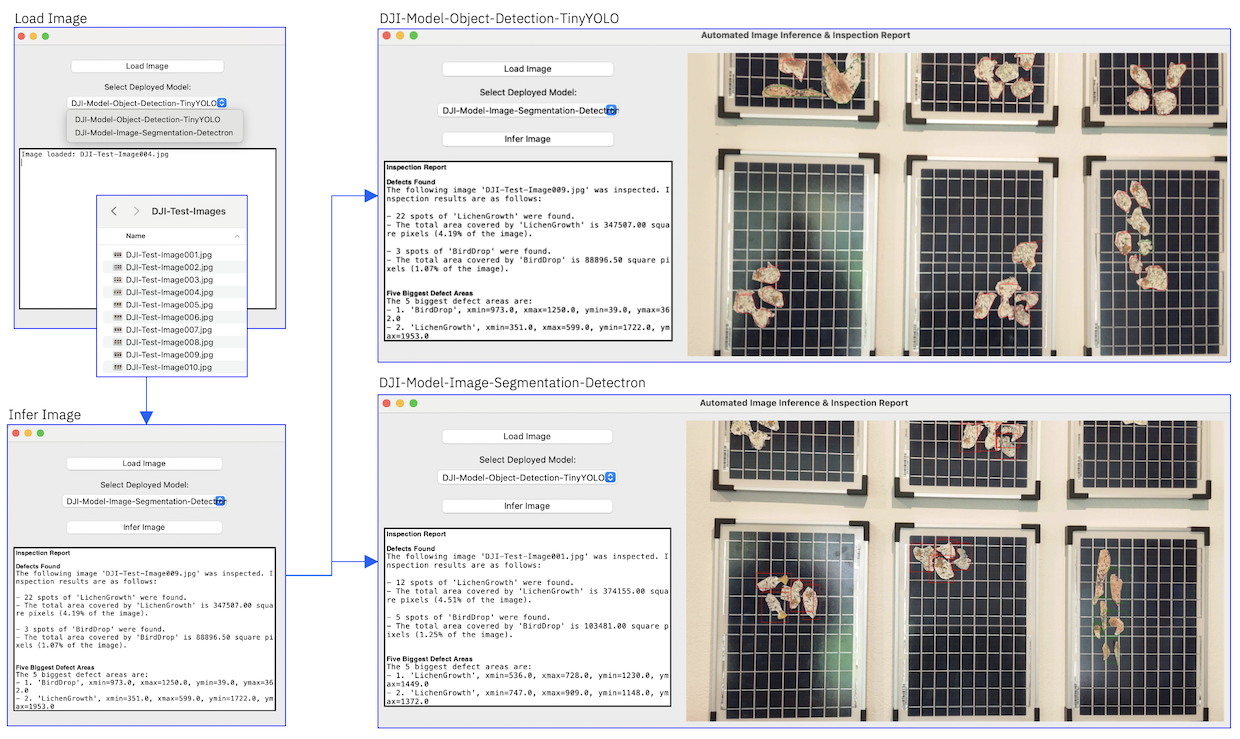

👏 **BRAVO - YOU MADE IT !** 💫